# Read Garmin GPX with heartrate
<h2>Thanks to Rich Signell for code to parse the XML</h2>

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from lxml import etree

%matplotlib inline

In [36]:
# fn = "activity_721671330.gpx" # Childs River
fn = "activity_725608981.gpx" # Tim Hyduncia Snow Row
tree = etree.parse(fn)

In [37]:
namespace = {'def': 'http://www.topografix.com/GPX/1/1',
             'gpxtpx': 'http://www.garmin.com/xmlschemas/TrackPointExtension/v1',
             'gpxx': 'http://www.garmin.com/xmlschemas/GpxExtensions/v3',
             'xsi': 'http://www.w3.org/2001/XMLSchema-instance'
             }

Within `trk` tags, find  `trkpt` elements get element values

In [38]:
elist = tree.xpath('./def:trk//def:trkpt',namespaces=namespace)
lonlat = [e.values() for e in elist]
lon = np.array([float(i[0]) for i in lonlat])
lat = np.array([float(i[1]) for i in lonlat])
print lon[0],lat[0],np.shape(lon)

-70.9183877986 42.3023049999 (736L,)


Within `trk` tags, find `time` elements and get element text

In [39]:
elist = tree.xpath('./def:trk//def:time',namespaces=namespace)
fmt = '%Y-%m-%dT%H:%M:%S.%fZ'
time = [datetime.strptime(d.text, fmt) for d in elist]
print time[0], np.shape(time)

2015-03-21 15:10:04 (736L,)


Within `trk` tags, find `hr` elements and get element text. CRS changed this to return an array of floats.

In [40]:
elist = tree.xpath("./def:trk//gpxtpx:hr", namespaces=namespace)
hr = np.array([float(e.text) for e in elist])
print hr[0], np.shape(hr)

143.0 (736L,)


Make the dataframe

In [41]:
df = pd.DataFrame.from_dict(dict(time=time, lon=lon, lat=lat, hr=hr))
df.set_index('time', drop=True, inplace=True)

In [42]:
df.head(5)

,hr,lat,lon
time,,,
2015-03-21 15:10:04,143,42.302305,-70.918388
2015-03-21 15:10:28,140,42.302343,-70.918295
2015-03-21 15:10:30,140,42.302356,-70.918274
2015-03-21 15:10:41,140,42.302423,-70.918188
2015-03-21 15:10:48,137,42.302463,-70.918148


Plot the heartrate

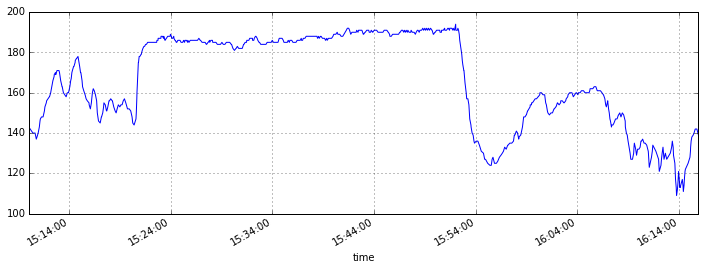

In [43]:
df['hr'].plot(figsize=(12,4));

<h2>Calculate speed, effort, and efficiency</h2>
I have not figured out how to do this in Pandas, or how to avoid the loop when calculating time differences. The .total_seconds() conversion does not work on np arrays of datetime.deltatime objects.

distm 8.71727567018 (735L,)
np.diff(time) 7.0 (735L,)
Effort:  0.595238095238 <type 'numpy.ndarray'> (736L,)


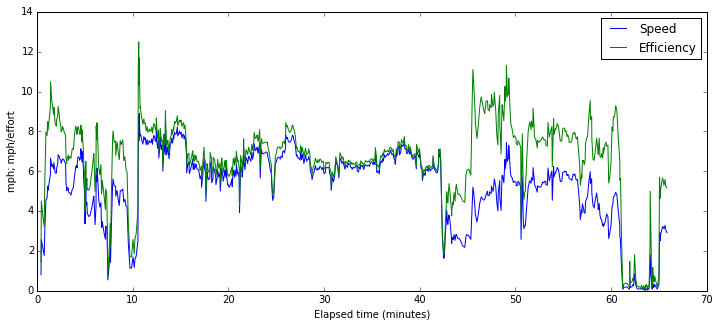

In [44]:
latr = np.radians(lat)
lonr = np.radians(lon)
dlatr = np.diff(latr)
dlonr = np.diff(lonr)
# Haversine formula for great circle
a = np.sin(dlatr/2.)**2 + np.cos(latr[0:-1]) * np.cos(latr[1:]) * np.sin(dlonr/2.)**2
c = 2. * np.arcsin(np.sqrt(a)) 
distm = 6367e3 * c
# distance is in meters.
print "distm",distm[0], np.shape(distm)

# this produces an array of datetime.deltatime objects
difft = np.diff(time)
print "np.diff(time)",difft[5].total_seconds(), np.shape(difft)

# there must be a better way:
dt = np.zeros_like(difft)
for i in np.arange(len(difft)):
    dt[i]= float(difft[i].total_seconds())
etime = np.cumsum(dt)

# speed in mph
speed = (distm/1609.34)/(dt/3600.)

# calculate effort as fraction of usable hr range
hr_rest = 68. # guess at resting rate
hr_ana = 194.  # this is actually Tim H's max. 162. # CRS anaerobic threshold
effort = (hr-hr_rest)/(hr_ana-hr_rest)

# calculate efficiency
eff = speed/effort[1:]

print "Effort: ",effort[0], type(effort), np.shape(effort)
fig = plt.figure(figsize=(12,5))
plt.plot(etime/60.,speed,label='Speed')
plt.plot(etime/60.,eff,label='Efficiency')
plt.ylabel('mph; mph/effort')
plt.xlabel('Elapsed time (minutes)')
plt.legend()
#plt.savefig('tim_snow_row.png')

<h2>Plot trackline lon/lat with Cartopy</h2>

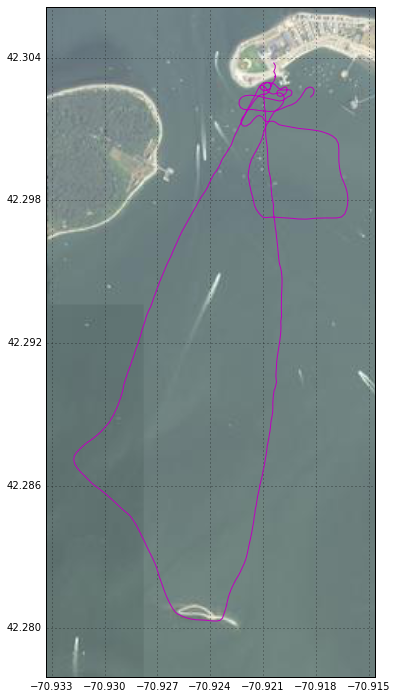

In [45]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial

geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
b=np.array([lon.min(), lat.min(), lon.max(), lat.max()])

plt.figure(figsize=(12,12))
# Open Source Imagery from MapQuest (max zoom = 16?)
tiler = MapQuestOpenAerial()
# Open Street Map (max zoom = 18?)
# tiler = OSM()
ax = plt.axes(projection=tiler.crs)
dx=b[2]-b[0]
dy=b[3]-b[1]
extent = (b[0]-0.1*dx,b[2]+0.1*dx,b[1]-0.1*dy,b[3]+0.1*dy)
ax.set_extent(extent, geodetic)
ax.add_image(tiler, 14)
plt.plot(lon[1:],lat[1:],'m-',transform=ccrs.PlateCarree());
# sheesh, this is embarassing
# 1) clip lat/lon and hr to length of other stuff (should actually interpolate to centerpoint)
lons = lon[1:]
lats = lat[1:]
# this does not work:
# plt.plot(lons,lats,transform=ccrs.PlateCarree(),marker='o',c=eff);
# nor does this:
# for i in np.arange(len(lons)):
#   plt.plot(lons[i],lats[i],transform=ccrs.PlateCarree(),marker='o',c=eff[i]);
# ax.scatter(lons,lats,transform=ccrs.PlateCarree(),marker='o',c=eff);
# ax.scatter(lons,lats,marker='o',c=eff);

gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

<h2>Plot effort in color</h2>

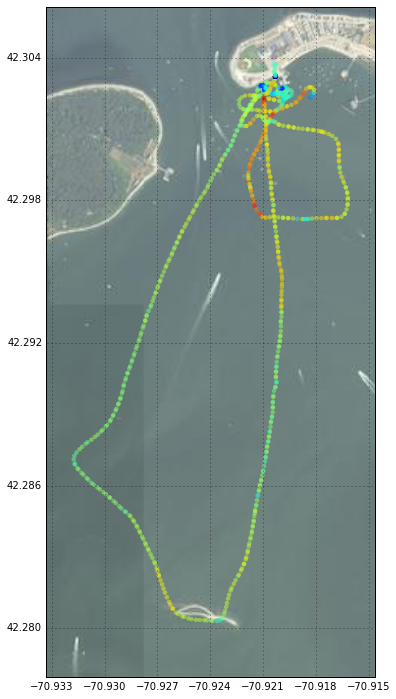

In [46]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapQuestOpenAerial

geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
b=np.array([lon.min(), lat.min(), lon.max(), lat.max()])

plt.figure(figsize=(12,12))
# Open Source Imagery from MapQuest (max zoom = 16?)
tiler = MapQuestOpenAerial()
# Open Street Map (max zoom = 18?)
#tiler = OSM()
ax = plt.axes(projection=tiler.crs)
dx=b[2]-b[0]
dy=b[3]-b[1]
extent = (b[0]-0.1*dx,b[2]+0.1*dx,b[1]-0.1*dy,b[3]+0.1*dy)
ax.set_extent(extent, geodetic)
ax.add_image(tiler, 14)
# sheesh, this is embarassing
# 1) clip lat/lon and hr to length of other stuff (should actually interpolate to centerpoint)
lons = lon[1:]
lats = lat[1:]
# this does not work:
# plt.plot(lons,lats,transform=ccrs.PlateCarree(),marker='o',c=eff);
# nor does this:
# for i in np.arange(len(lons)):
#   plt.plot(lons[i],lats[i],transform=ccrs.PlateCarree(),marker='o',c=eff[i]);
# or this
# ax.scatter(lons,lats,marker='o',c=eff);
# Filipe's solution:
kw = dict(alpha=0.5, lw=0 )
ax.scatter(lons,lats,transform=ccrs.PlateCarree(),marker='o',c=eff.tolist(),**kw);
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#plt.savefig('snow_row_map.png')